In [16]:
import pandas as pd
data_df = pd.read_csv('https://query.data.world/s/afb7vfbdtzot2kgsqa3obq2jqra5y2')

In [17]:
import numpy as np
np.random.seed(12345)
%matplotlib inline
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [18]:
data_df.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


In [19]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
Name           1340 non-null object
GP             1340 non-null int64
MIN            1340 non-null float64
PTS            1340 non-null float64
FGM            1340 non-null float64
FGA            1340 non-null float64
FG%            1340 non-null float64
3P Made        1340 non-null float64
3PA            1340 non-null float64
3P%            1329 non-null float64
FTM            1340 non-null float64
FTA            1340 non-null float64
FT%            1340 non-null float64
OREB           1340 non-null float64
DREB           1340 non-null float64
REB            1340 non-null float64
AST            1340 non-null float64
STL            1340 non-null float64
BLK            1340 non-null float64
TOV            1340 non-null float64
TARGET_5Yrs    1340 non-null float64
dtypes: float64(19), int64(1), object(1)
memory usage: 219.9+ KB


# Class Distribution

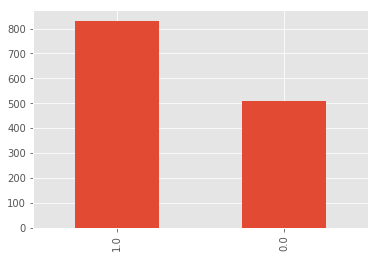

In [20]:
ax = data_df.TARGET_5Yrs.value_counts().plot(kind='bar')

# Mean and STD of Both Groups`

In [21]:
data_df = data_df.drop('Name', axis=1)

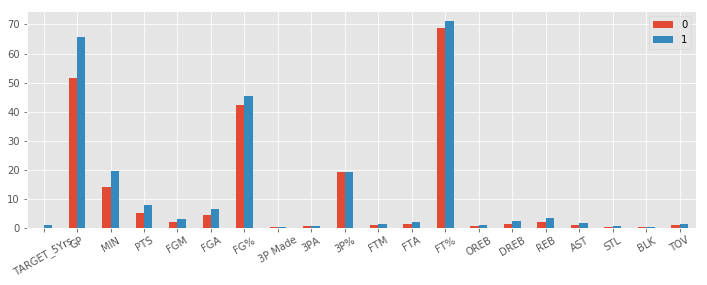

In [22]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
data_df.groupby('TARGET_5Yrs', as_index=False).mean().T.plot(kind='bar', ax=ax, rot=30)

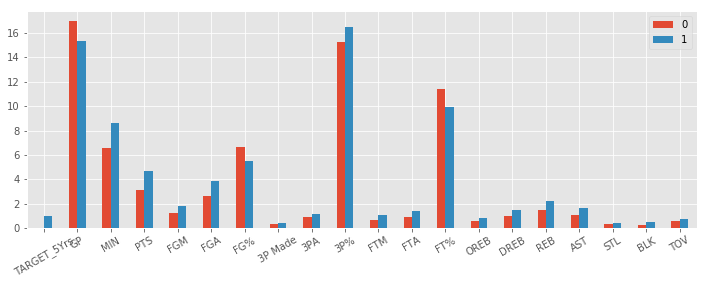

In [23]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
data_df.groupby('TARGET_5Yrs', as_index=False).std().T.plot(kind='bar', ax=ax, rot=30)

# Boxplot Per Feature

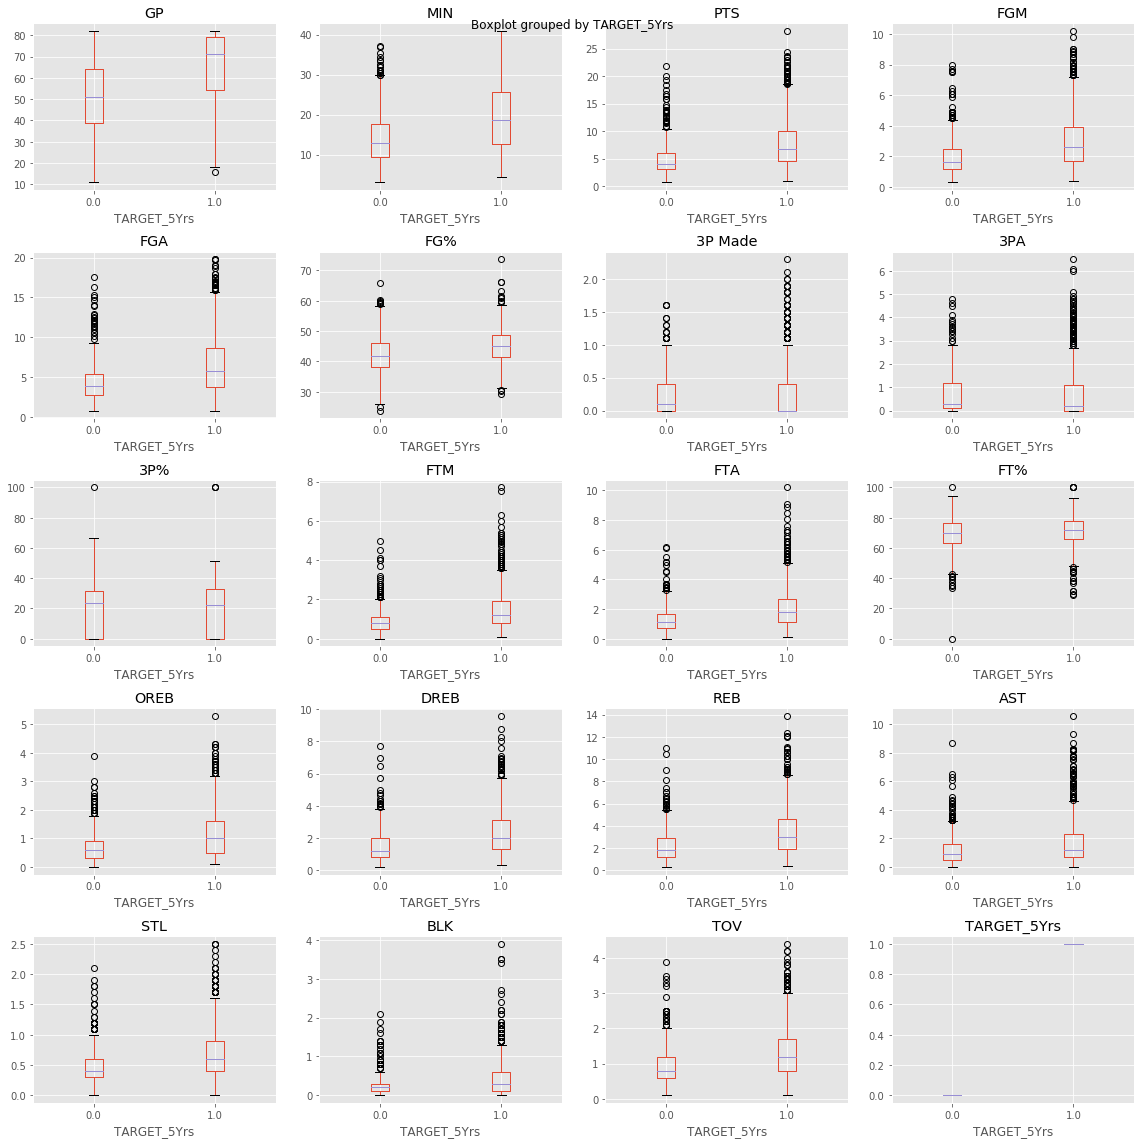

In [24]:
_, axes = plt.subplots(5, 4, sharey=False, figsize=(16, 16))

for i, col in enumerate(data_df.columns):
    row_i, col_i = divmod(i, 4)
    _ = data_df.boxplot(col, ax=axes[row_i][col_i], by='TARGET_5Yrs')
    
plt.tight_layout()

# First Model: Naive Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif


pipeline = Pipeline([
    ('selector', SelectKBest(f_classif, k=5)),
    ('model', GaussianNB(priors=[0.5, 0.5]))
])

cv = StratifiedKFold(n_splits=10, random_state=12345)

results = cross_validate(
    pipeline,
    data_df.drop(['TARGET_5Yrs', '3P%'], axis=1).values,
    data_df.TARGET_5Yrs.values,
    cv=cv,
    scoring='f1',
    return_train_score=True
)

results = pd.DataFrame.from_dict(results)

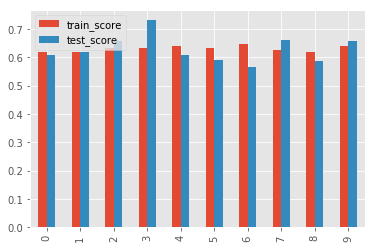

In [26]:
results.loc[:, ['train_score', 'test_score']].plot(kind='bar')

In [27]:
results.mean()

fit_time       0.002678
score_time     0.001037
test_score     0.628162
train_score    0.630542
dtype: float64

# Logistic Regression`

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler


pipeline = Pipeline([
    ('selector', SelectKBest(f_classif, k=10)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver='lbfgs'))
])

cv = StratifiedKFold(n_splits=10, random_state=12345)

results = cross_validate(
    pipeline,
    data_df.drop(['TARGET_5Yrs', '3P%'], axis=1).values,
    data_df.TARGET_5Yrs.values,
    scoring='f1',
    cv=cv,
    return_train_score=True
)

results = pd.DataFrame.from_dict(results)

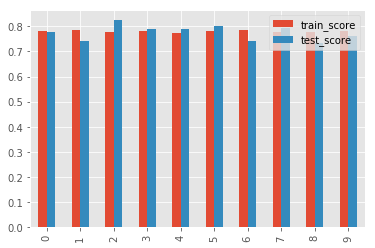

In [29]:
results.loc[:, ['train_score', 'test_score']].plot(kind='bar')

In [30]:
results.mean()

fit_time       0.018507
score_time     0.000974
test_score     0.774837
train_score    0.779661
dtype: float64

# Hyperparameter Optimization

In [38]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('selector', SelectKBest(f_classif, k=10)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver='lbfgs'))
])

cv = StratifiedKFold(n_splits=10, random_state=12345)

param_grid = {'model__C': [0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(pipeline, param_grid, scoring='f1', cv=cv, return_train_score=True)
gs = gs.fit(
    data_df.drop(['TARGET_5Yrs', '3P%'], axis=1).values,
    data_df.TARGET_5Yrs.values
)


gs.best_params_

{'model__C': 0.1}

# Best Model

In [39]:
pipeline = Pipeline([
    ('selector', SelectKBest(f_classif, k=10)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver='lbfgs', C=0.1))
])

cv = StratifiedKFold(n_splits=10, random_state=12345)

results = cross_validate(
    pipeline,
    data_df.drop(['TARGET_5Yrs', '3P%'], axis=1).values,
    data_df.TARGET_5Yrs.values,
    scoring='f1',
    cv=cv,
    return_train_score=True
)

results = pd.DataFrame.from_dict(results)

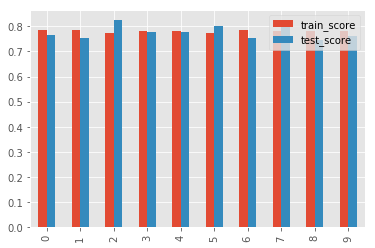

In [40]:
results.loc[:, ['train_score', 'test_score']].plot(kind='bar')

In [41]:
results.mean()

fit_time       0.011130
score_time     0.000856
test_score     0.777136
train_score    0.781080
dtype: float64